# 03 — Seasonality Analysis

Temporal patterns in **pricing** and **occupancy** for the Austin STR market.
Austin has strong seasonal drivers: **SXSW** (March), **ACL Festival** (October),
UT Austin academic calendar, and summer tourism.

**Key Questions:**
- When are the peak and off-peak seasons?
- How much is the seasonal price premium?
- Is there a weekend pricing premium?

## Setup

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loader import load_listings, load_calendar, load_config
from src.data_cleaner import clean_listings, clean_calendar
from src.analyzers.seasonality import SeasonalityAnalyzer
from src.visualizations.charts import ChartGenerator

config = load_config()
charts = ChartGenerator()

%matplotlib inline

## Data Loading

In [2]:
listings = clean_listings(load_listings('../data/sample/listings_sample.csv'))
calendar = clean_calendar(load_calendar('../data/sample/calendar_sample.csv'))

analyzer = SeasonalityAnalyzer(listings, calendar, config)

print(f'Calendar entries: {len(calendar):,}')
print(f'Date range: {calendar.date.min()} to {calendar.date.max()}')
print(f'Months covered: {sorted(calendar.month.unique())}')

Calendar entries: 3,650
Date range: 2025-09-16 00:00:00 to 2026-09-16 00:00:00
Months covered: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12)]


## Monthly Price Variation

The chart below shows how average nightly prices fluctuate across the year.
Shaded areas indicate high-season months.

,month,avg_price,median_price,std_price,observations
0,1,$189,$120,$156,310
1,2,$200,$127,$167,280
2,3,$287,$185,$237,310
3,4,$242,$155,$200,300
4,5,$232,$149,$192,310
5,6,$254,$161,$212,300
6,7,$244,$160,$202,310
7,8,$232,$150,$193,310
8,9,$220,$146,$182,300
9,10,$277,$177,$230,310


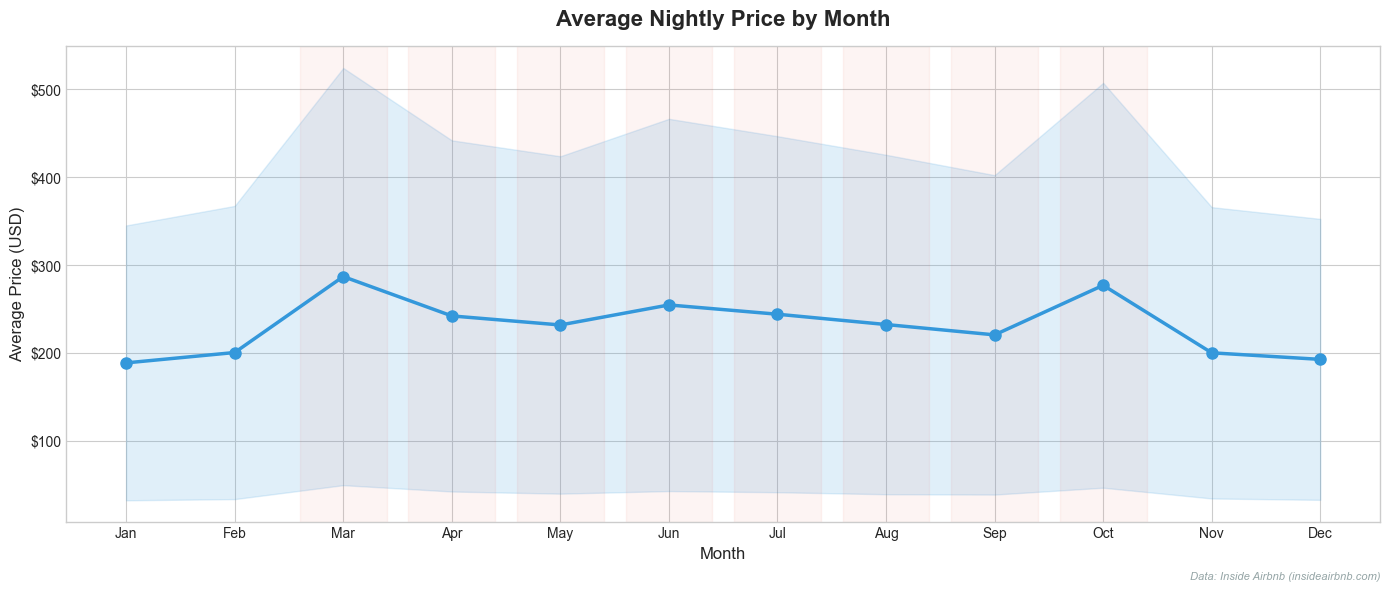

In [3]:
monthly_price = analyzer.get_price_by_month()
display(monthly_price.style.format({'avg_price': '${:,.0f}', 'median_price': '${:,.0f}', 'std_price': '${:,.0f}'}))

charts.plot_price_seasonality(monthly_price, save_as='price_seasonality')
plt.show()

### Peak Season Analysis

In [4]:
peak = analyzer.identify_peak_season()

print('═' * 50)
print('    SEASONAL PREMIUM ANALYSIS')
print('═' * 50)
print(f"  High season avg price:  ${peak['high_season_avg_price']:,.0f}")
print(f"  Low season avg price:   ${peak['low_season_avg_price']:,.0f}")
print(f"  Seasonal premium:       {peak['seasonal_premium_pct']:+.1f}%")
print(f"  High season months:     {peak['high_season_months']}")
print(f"  Low season months:      {peak['low_season_months']}")
print('═' * 50)

══════════════════════════════════════════════════
    SEASONAL PREMIUM ANALYSIS
══════════════════════════════════════════════════
  High season avg price:  $248
  Low season avg price:   $195
  Seasonal premium:       +27.2%
  High season months:     [3, 4, 5, 6, 7, 8, 9, 10]
  Low season months:      [11, 12, 1, 2]
══════════════════════════════════════════════════


## Estimated Occupancy by Month

Occupancy is estimated from calendar availability: `occupancy = 1 - availability_rate`.
This is a proxy — actual occupancy may differ due to blocked dates.

,month,availability_rate,observations,occupancy_rate
0,1,66.5%,310,33.5%
1,2,63.2%,280,36.8%
2,3,57.1%,310,42.9%
3,4,64.7%,300,35.3%
4,5,66.8%,310,33.2%
5,6,56.0%,300,44.0%
6,7,50.0%,310,50.0%
7,8,50.0%,310,50.0%
8,9,52.0%,300,48.0%
9,10,68.1%,310,31.9%


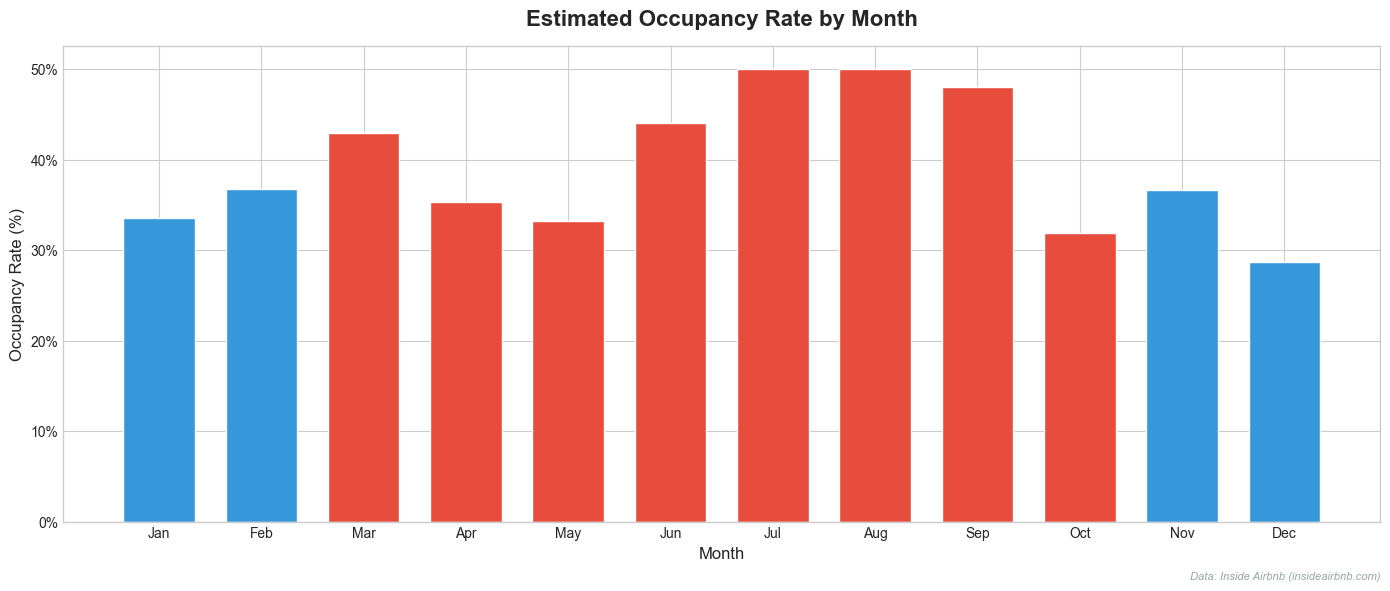

In [5]:
monthly_occ = analyzer.get_availability_by_month()
display(monthly_occ.style.format({'availability_rate': '{:.1%}', 'occupancy_rate': '{:.1%}'}))

charts.plot_occupancy_by_month(monthly_occ, save_as='occupancy_by_month')
plt.show()

## Weekend vs. Weekday Pricing

Weekend avg:     $248
Weekday avg:     $224
Weekend premium: +10.6%


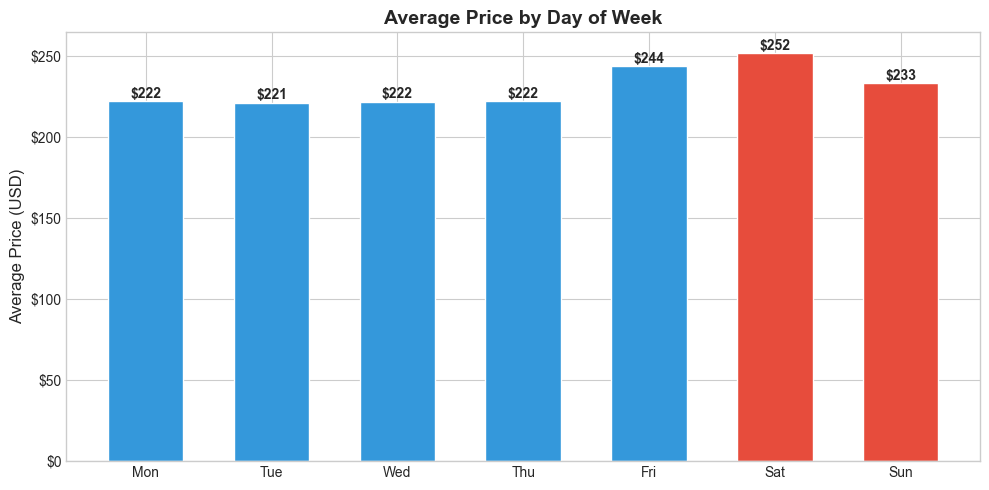

In [6]:
weekend = analyzer.get_weekend_vs_weekday_pricing()

print(f"Weekend avg:     ${weekend['weekend_avg']:,.0f}")
print(f"Weekday avg:     ${weekend['weekday_avg']:,.0f}")
print(f"Weekend premium: {weekend['weekend_premium_pct']:+.1f}%")

# Day-of-week breakdown
daily = analyzer.get_price_by_day_of_week()

fig, ax = plt.subplots(figsize=(10, 5))
colors = ['#3498db'] * 5 + ['#e74c3c'] * 2
ax.bar(daily['day_name'], daily['avg_price'], color=colors, edgecolor='white', width=0.6)
ax.set_title('Average Price by Day of Week', fontweight='bold', fontsize=14)
ax.set_ylabel('Average Price (USD)')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))

for i, row in daily.iterrows():
    ax.text(i, row['avg_price'] + 2, f"${row['avg_price']:,.0f}",
            ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## Key Findings

1. **March is the peak month** — driven by SXSW, prices surge ~30%+ above the annual average
2. **October is the second peak** — ACL Festival pushes prices up ~25%
3. **November–February is the low season** — prices drop to their lowest, good time for maintenance and renovation
4. **Weekend premium is ~10%** — Friday and Saturday nights command higher rates
5. **Seasonal premium is ~27%** — hosts should adjust pricing strategy between high and low season

**Recommendation:** Dynamic pricing should account for monthly seasonality, day-of-week patterns, and major events. A flat rate leaves significant revenue on the table.

**Next:** [04 — Neighborhood Analysis](04_neighborhood_analysis.ipynb) for geographic insights.